In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.layers import BatchNormalization, Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16
import os

In [8]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define paths
train_dataset_path = "F:\\archive\\data\\puzzle_2x2\\train\\"
train_label_path = "F:\\archive\\data\\puzzle_2x2\\train_filtered.csv"

test_dataset_path = "F:\\archive\\data\\puzzle_2x2\\test\\"
test_label_path = "F:\\archive\\data\\puzzle_2x2\\test.csv"

validation_dataset_path = "F:\\archive\\data\\puzzle_2x2\\valid\\"
validation_label_path = "F:\\archive\\data\\puzzle_2x2\\valid.csv"

def load_data(dataset_path, label_path, percentage=100):
    df = pd.read_csv(label_path)
    images = []
    labels = []

    # Select a subset of data based on the percentage
    num_samples = int(len(df) * (percentage / 100))
    df = df.head(num_samples)

    for index, row in df.iterrows():
        image_name = row['image']  # Get the image name from the dataframe
        image_path = os.path.join(dataset_path, image_name)  # Construct the full image path
        image = tf.keras.preprocessing.image.load_img(image_path, target_size=(100, 100))
        image = tf.keras.preprocessing.image.img_to_array(image)
        images.append(image)

        # Convert label permutation to integer index
        label_permutation = [int(x) for x in row['label'].split()]
        label_index = get_permutation_index(label_permutation)
        
        labels.append(label_index)

    return np.array(images), np.array(labels)

def get_permutation_index(perm):
    # Define all possible permutations of [0, 1, 2, 3]
    permutations = [
        [0, 1, 2, 3], [0, 1, 3, 2], [0, 2, 1, 3], [0, 2, 3, 1],
        [0, 3, 1, 2], [0, 3, 2, 1], [1, 0, 2, 3], [1, 0, 3, 2],
        [1, 2, 0, 3], [1, 2, 3, 0], [1, 3, 0, 2], [1, 3, 2, 0],
        [2, 0, 1, 3], [2, 0, 3, 1], [2, 1, 0, 3], [2, 1, 3, 0],
        [2, 3, 0, 1], [2, 3, 1, 0], [3, 0, 1, 2], [3, 0, 2, 1],
        [3, 1, 0, 2], [3, 1, 2, 0], [3, 2, 0, 1], [3, 2, 1, 0]
    ]
    # Find the index of the given permutation in the list of permutations
    index = permutations.index(perm)
    return index


In [9]:
# Example usage:
train_images, train_labels = load_data(train_dataset_path, train_label_path, percentage=100)
test_images, test_labels = load_data(test_dataset_path, test_label_path, percentage=100)
validation_images, validation_labels = load_data(validation_dataset_path, validation_label_path, percentage=100)
print(train_labels.shape)

# Normalize pixel values to be between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0
validation_images = validation_images / 255.0

(21600,)


In [12]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Model Checkpoint
checkpoint = ModelCheckpoint('best_2x2_VGG_model.h5', monitor='val_accuracy', save_best_only=True)

# Define the base model (VGG16) without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

# Learning Rate Scheduler
def lr_scheduler(epoch, lr):
    if epoch and epoch % 4 == 0:
        return lr * 0.8  # Reduce learning rate by 20% every 10 epochs
    return lr

lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

# Freeze the base model layers
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)  # L2 regularization
x = BatchNormalization()(x)  # Batch normalization
x = Dropout(0.5)(x)  # Dropout regularization
output = Dense(24, activation='softmax')(x)

# Create the final model
model = models.Model(inputs=base_model.input, outputs=output)

# Compile the model with RMSprop optimizer and categorical cross-entropy loss
model.compile(optimizer=RMSprop(learning_rate=0.001),  # RMSprop optimizer
              loss='sparse_categorical_crossentropy',  # Sparse categorical cross-entropy
              metrics=['accuracy'])

# Train the model with batch normalization, dropout, and RMSprop optimizer
history = model.fit(
    train_images, train_labels, 
    batch_size=256,
    epochs=50,
    validation_data=(validation_images, validation_labels),
    callbacks=[ early_stopping,checkpoint,lr_scheduler_callback],
    verbose=1)

# Evaluate the model on test data 
test_loss, test_acc = model.evaluate(test_images, test_labels)

# Save the final model
model.save('final_2x2_VGG_model.h5')

# Load the best model
best_model = models.load_model('best_2x2_VGG_model.h5')

# Evaluate the best model
best_model_loss, best_model_acc = best_model.evaluate(test_images, test_labels)

# Predict labels for test data
predictions = best_model.predict(test_images)
predicted_permutations = np.argmax(predictions, axis=1)  # Get the index of the highest probability for each sample

Epoch 1/50
85/85 [==============================] - 704s 8s/step - loss: 3.5245 - accuracy: 0.1411 - val_loss: 12.5445 - val_accuracy: 0.0935 - lr: 0.0010
Epoch 2/50
85/85 [==============================] - 703s 8s/step - loss: 1.9968 - accuracy: 0.4272 - val_loss: 3.1305 - val_accuracy: 0.3247 - lr: 0.0010
Epoch 3/50
85/85 [==============================] - 703s 8s/step - loss: 1.4448 - accuracy: 0.5746 - val_loss: 2.8583 - val_accuracy: 0.3403 - lr: 0.0010
Epoch 4/50
85/85 [==============================] - 703s 8s/step - loss: 1.1672 - accuracy: 0.6442 - val_loss: 2.6530 - val_accuracy: 0.4338 - lr: 0.0010
Epoch 5/50
85/85 [==============================] - 708s 8s/step - loss: 0.8985 - accuracy: 0.7248 - val_loss: 1.8796 - val_accuracy: 0.5403 - lr: 8.0000e-04
Epoch 6/50
85/85 [==============================] - 710s 8s/step - loss: 0.6852 - accuracy: 0.7892 - val_loss: 2.4864 - val_accuracy: 0.4779 - lr: 8.0000e-04
Epoch 7/50
85/85 [==============================] - 709s 8s/step - 

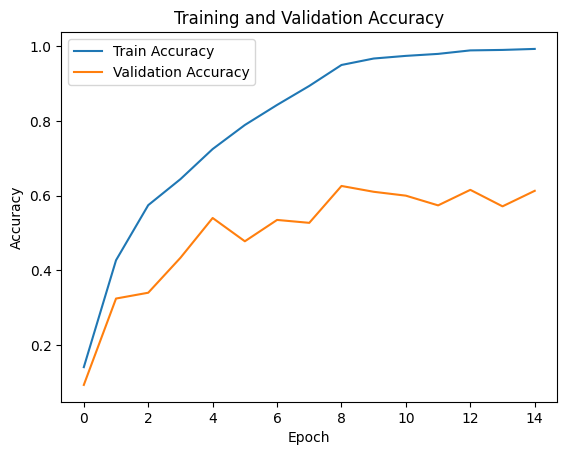

In [13]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('2x2_VGGNet_accuracy_plot.png')

# Write final testing accuracy to a text file
with open('2x2_VGGNet_testing_accuracy.txt', 'w') as f:
    f.write('Final Test accuracy: {:.4f}\n'.format(test_acc))
    f.write('Best Model Test accuracy: {:.4f}\n'.format(best_model_acc))